<a href="https://colab.research.google.com/github/dtabuena/Images/blob/main/Analyzing_Confocal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install python-bioformats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import numpy as np
import javabridge
import bioformats
import skimage
from skimage import filters
from matplotlib import pyplot as plt
javabridge.start_vm(class_path=bioformats.JARS)

In [9]:
!wget 'https://www.dropbox.com/s/ec4squfg12j7tm7/RNF182_08-12-22_S001_CA3_40X_2XZOOM_1_.oir'

--2022-09-22 19:14:43--  https://www.dropbox.com/s/ec4squfg12j7tm7/RNF182_08-12-22_S001_CA3_40X_2XZOOM_1_.oir
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/ec4squfg12j7tm7/RNF182_08-12-22_S001_CA3_40X_2XZOOM_1_.oir [following]
--2022-09-22 19:14:44--  https://www.dropbox.com/s/raw/ec4squfg12j7tm7/RNF182_08-12-22_S001_CA3_40X_2XZOOM_1_.oir
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb3c7cf6682c30096a1a7a0aa8c.dl.dropboxusercontent.com/cd/0/inline/BtfWNblLqaLNFffzrXpF6nFjR-r9EwvmbkP1Wr4-VkMpcJtcnzf6vDfp0YRyIYXOsw5w8f36cuwEwznlxe-au9vY0OaYlw6sHvsZAaOGnp-EQCTuqYnUDLLoWNkr-Sh3aNFEBl7Ne8cOqgBSZM8paijzKmBqzu7SX-bnUlTX9P8ipw/file# [following]
--2022-09-22 19:14:45--  https://ucb3c7cf6682c30096a1a7a0aa8c.dl.dropboxusercontent.com/c

In [175]:
my_reader = bioformats.get_image_reader('my_image', 'RNF182_08-12-22_S001_CA3_40X_2XZOOM_1_.oir')

c_dim = my_reader.rdr.getSizeC()
z_dim = my_reader.rdr.getSizeZ()
x_dim = my_reader.rdr.getSizeX()
y_dim = my_reader.rdr.getSizeY()
print(x_dim,y_dim,c_dim,z_dim)

image = np.empty([x_dim,y_dim,c_dim,z_dim])
for zi in range(z_dim):
    img_zi = my_reader.read(c=None, z=zi,rescale=True)
    image[:,:,:,zi] = img_zi


image_zproj = np.sum(image,axis=3)
image = np.expand_dims(image_zproj, axis=-1)
print(image.shape)
for ci in range(image.shape[2]):
    cim = image[:,:,ci,:]
    max= np.percentile(cim.flatten(),95)
    cim = cim/max
    image[:,:,ci,:] = cim

800 800 3 10
(800, 800, 3, 1)


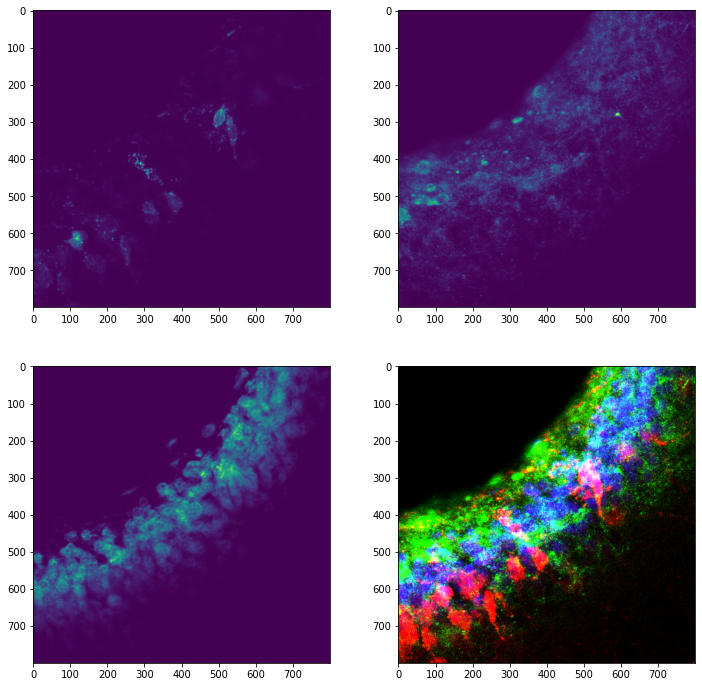

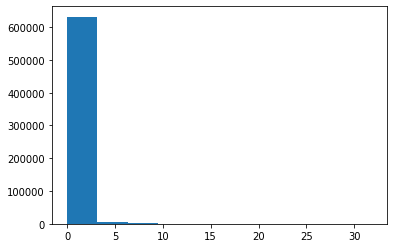

In [177]:
fig,ax = plt.subplots(2,2,figsize=[12,12])
ax = ax.flatten()
red_chan = image[:,:,1,:]
green_chan = image[:,:,0,:]
blue_chan = image[:,:,2,:]


composite = np.stack([red_chan,green_chan,blue_chan],axis=-2)

ax[0].imshow(red_chan[:,:,0])
ax[1].imshow(green_chan[:,:,0])
ax[2].imshow(blue_chan[:,:,0])
ax[3].imshow(composite[:,:,:,0])
plt.show()


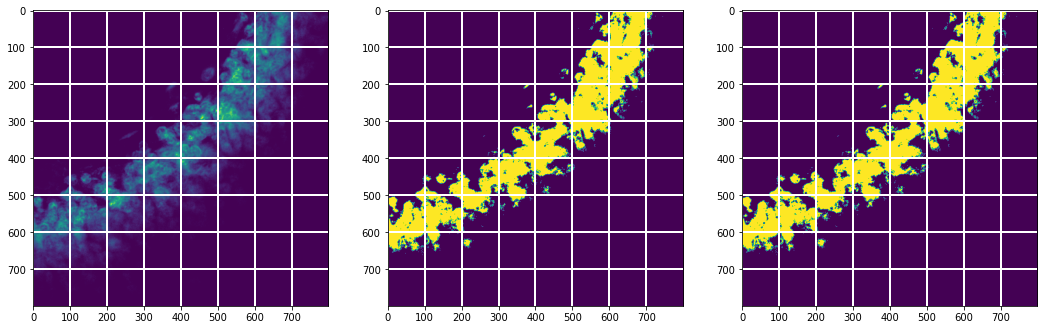

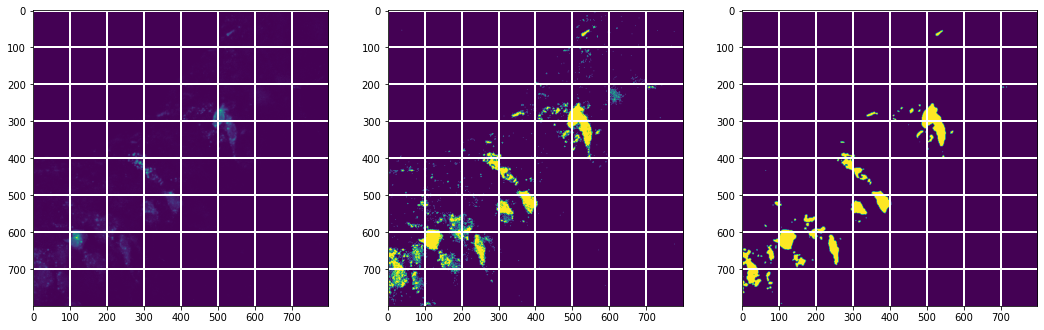

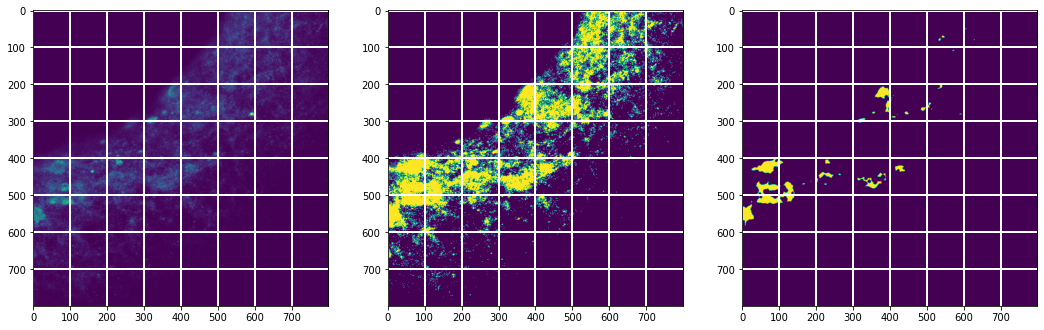

In [178]:
### threhold neun
zi = 0
zero_log = 1



image_c2 = image[:,:,2,:]

c2_vals = image_c2.flatten()
neu_thresh = filters.threshold_otsu(c2_vals)
neu_mask = image_c2>neu_thresh
neu_mask_b = filters.gaussian(neu_mask,.1)>0.8

fig,ax = plt.subplots(1,3,figsize=[18,6])
ax[0].imshow(image_c2[:,:,zi])
ax[1].imshow(neu_mask[:,:,zi])
ax[2].imshow(neu_mask_b[:,:,zi])

ax[0].grid(color='w', linestyle='-', linewidth=2)
ax[1].grid(color='w', linestyle='-', linewidth=2)
ax[2].grid(color='w', linestyle='-', linewidth=2)

plt.show()

############## Red Mask
image_c1 = image[:,:,1,:]
# image_c1 = filters.gaussian(image_c1,2)
c1_vals = image_c1.flatten()
mcher_thresh = filters.threshold_otsu(np.log(c1_vals+zero_log))
mcher_mask = image_c1>(filters.threshold_otsu(c1_vals)*.3)
# mcher_mask = np.log(image_c1+zero_log)>mcher_thresh*1
mcher_mask_b = filters.gaussian(mcher_mask,2)>0.6

fig,ax = plt.subplots(1,3,figsize=[18,6])
ax[0].imshow(image_c1[:,:,zi])
ax[1].imshow(mcher_mask[:,:,zi])
ax[2].imshow(mcher_mask_b[:,:,zi])

ax[0].grid(color='w', linestyle='-', linewidth=2)
ax[1].grid(color='w', linestyle='-', linewidth=2)
ax[2].grid(color='w', linestyle='-', linewidth=2)

plt.show()

############## green Mask
image_c0 = image[:,:,0,:]
# image_c0 = filters.gaussian(image_c0,0)
c0_vals = image_c0.flatten()
# crisp_thresh = filters.threshold_otsu(np.log(c0_vals+zero_log))
crisp_mask = image_c0>(filters.threshold_otsu(c0_vals)*1)
# crisp_mask = np.log(image_c0+zero_log)>crisp_thresh*1
crisp_mask_b = filters.gaussian(crisp_mask,2.5)>.99

fig,ax = plt.subplots(1,3,figsize=[18,6])
ax[0].imshow(image_c0[:,:,zi])
ax[1].imshow(crisp_mask[:,:,zi])
ax[2].imshow(crisp_mask_b[:,:,zi])

ax[0].grid(color='w', linestyle='-', linewidth=2)
ax[1].grid(color='w', linestyle='-', linewidth=2)
ax[2].grid(color='w', linestyle='-', linewidth=2)
plt.show()

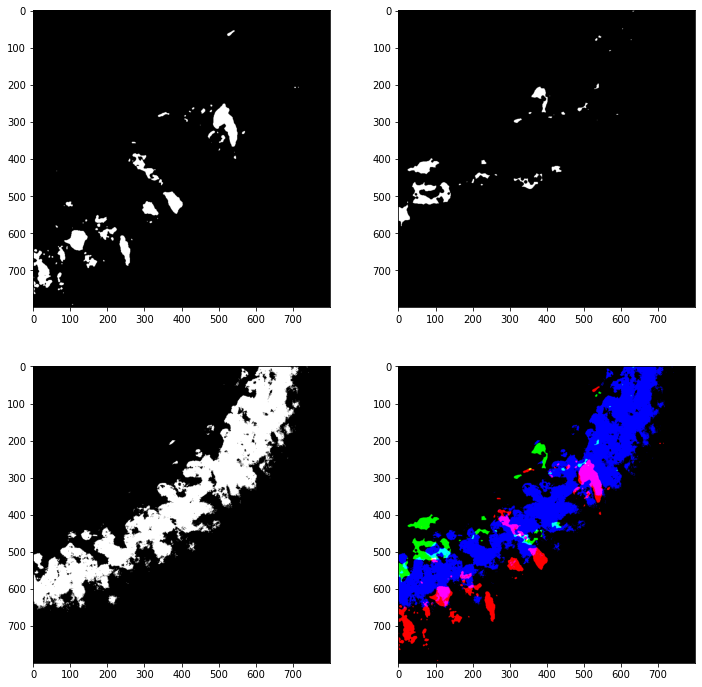

In [179]:
fig,ax = plt.subplots(2,2,figsize=[12,12])
ax = ax.flatten()
red_chan = mcher_mask_b
green_chan = crisp_mask_b
blue_chan = neu_mask_b
zi = 0
composite = np.stack([red_chan,green_chan,blue_chan],axis=-2)*1.0

ax[0].imshow(red_chan[:,:,zi],cmap='gray')
ax[1].imshow(green_chan[:,:,zi],cmap='gray')
ax[2].imshow(blue_chan[:,:,zi],cmap='gray')
ax[3].imshow(composite[:,:,:,zi])
plt.show()

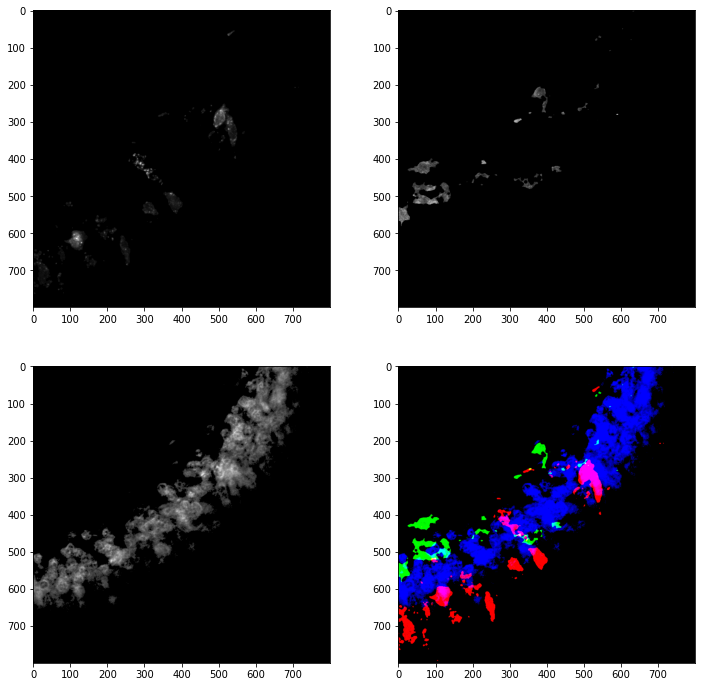

In [180]:
fig,ax = plt.subplots(2,2,figsize=[12,12])
ax = ax.flatten()
red_chan = mcher_mask_b*image[:,:,1]
green_chan = crisp_mask_b*image[:,:,0]
blue_chan = neu_mask_b*image[:,:,2]
zi = 0
composite = np.stack([red_chan,green_chan,blue_chan],axis=-2)*1.0

ax[0].imshow(red_chan[:,:,zi],cmap='gray')
ax[1].imshow(green_chan[:,:,zi],cmap='gray')
ax[2].imshow(blue_chan[:,:,zi],cmap='gray')
ax[3].imshow(composite[:,:,:,zi])
plt.show()

In [155]:
neu_mask_flat = neu_mask_b.flatten()
red_vals = mcher_mask_b.flatten()
green_vals = crisp_mask_b.flatten()

red_pix_in_cell = red_vals[neu_mask_flat]
green_pix_in_cell = green_vals[neu_mask_flat]

rpos_gpos = np.logical_and(red_pix_in_cell,green_pix_in_cell)
rpos_gneg = np.logical_and(red_pix_in_cell,np.logical_not(green_pix_in_cell))
rneg_gpos = np.logical_and(np.logical_not(red_pix_in_cell),green_pix_in_cell)
rneg_gneg = np.logical_and(np.logical_not(red_pix_in_cell),np.logical_not(green_pix_in_cell))



print('rpos_gpos',np.sum(rpos_gpos) )
print('rpos_gneg',np.sum(rpos_gneg) )
print('rneg_gpos',np.sum(rneg_gpos) )
print('rneg_gneg',np.sum(rneg_gneg) )
print('')

print('P(G+|R+) ',  np.round(np.sum(rpos_gpos) /(np.sum(rpos_gneg)+np.sum(rpos_gpos)) *100,1)  )
print('P(G-|R+) ',  np.round(np.sum(rpos_gneg) /(np.sum(rpos_gneg)+np.sum(rpos_gpos)) *100,1)  )

print('P(G+|R-) ',  np.round(np.sum(rneg_gpos) /(np.sum(rneg_gneg)+np.sum(rneg_gpos)) *100,1)  )
print('P(G-|R-) ',  np.round(np.sum(rneg_gneg) /(np.sum(rneg_gneg)+np.sum(rneg_gpos)) *100,1)  )
print('')

print('P(G+) ', np.round(np.mean(green_pix_in_cell)*100,1))
print('P(G-) ',  np.round(100-np.mean(green_pix_in_cell)*100,1))
print('P(R+) ',  np.round(np.mean(red_pix_in_cell)*100,1))
print('P(R-) ',  np.round(100-np.mean(red_pix_in_cell)*100,1))


import scipy
table = [[np.sum(rpos_gneg),np.sum(rpos_gpos)],[np.sum(rneg_gneg),np.sum(rneg_gpos)] ]
odds_ratio, p_val = scipy.stats.fisher_exact(table, alternative='two-sided')
print('p=',p_val)

rpos_gpos 133
rpos_gneg 7030
rneg_gpos 2090
rneg_gneg 86526

P(G+|R+)  1.9
P(G-|R+)  98.1
P(G+|R-)  2.4
P(G-|R-)  97.6

P(G+)  2.3
P(G-)  97.7
P(R+)  7.5
P(R-)  92.5
p= 0.006221417211416896
